In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Tue Jun 15 20:26:15 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import os
import random
import skimage
from skimage.exposure import equalize_adapthist
import numpy as np
import tensorflow as tf
import tensorflow.keras
from PIL import Image
from matplotlib import pyplot as plt
from keras_preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from numpy import asarray
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.applications.inception_v3 import InceptionV3
from numpy import asarray
from matplotlib import pyplot as plt

In [ ]:
!unrar x "/content/drive/MyDrive/COVID-CT-MD-1.rar" "/content/drive/MyDrive/"

Görüntülenen çıkış son 5000 satıra kısaltıldı.
Extracting  /content/drive/MyDrive/COVID-CT-MD/2HEALTHY/normal027-IM0053-clahe.png      78%  OK 
Extracting  /content/drive/MyDrive/COVID-CT-MD/2HEALTHY/normal027-IM0054-clahe.png      78%  OK 
Extracting  /content/drive/MyDrive/COVID-CT-MD/2HEALTHY/normal027-IM0055-clahe.png      78%  OK 
Extracting  /content/drive/MyDrive/COVID-CT-MD/2HEALTHY/normal027-IM0056-clahe.png      78%  OK 
Extracting  /content/drive/MyDrive/COVID-CT-MD/2HEALTHY/normal027-IM0057-clahe.png      78%  OK 
Extracting  /content/drive/MyDrive/COVID-CT-MD/2HEALTHY/normal027-IM0058-clahe.png      78%  OK 
Extracting  /content/drive/MyDrive/COVID-CT-MD/2HEALTHY/normal027-IM0059-clahe.png      78%  OK 
Extracting  /content/drive/MyDrive/COVID-CT-MD/2HEALTHY/normal027-IM0060-clahe.png      78%  OK 
Extracting  /content/drive/MyDrive/COVID-CT-MD/2HEALTHY/normal027-IM0061-clahe.png      78%  OK 

In [ ]:
len(os.listdir("/content/drive/MyDrive/COVID-CT-MD/0CAP"))

8093

In [ ]:
len(os.listdir("/content/drive/MyDrive/COVID-CT-MD/1COVID"))

8404

In [ ]:
len(os.listdir("/content/drive/MyDrive/COVID-CT-MD/2HEALTHY"))

8290

In [ ]:
DIR = "/content/drive/MyDrive/COVID-CT-MD/"
CATEGORIES = ["0CAP","1COVID","2HEALTHY"]
IMG_SIZE = 200
IMG_SHAPE=(200,200,3)

In [ ]:
dataset_train=tf.keras.preprocessing.image_dataset_from_directory(
    DIR,
    labels="inferred",
    label_mode="int",
    class_names=CATEGORIES,
    color_mode="rgb",
    image_size=(IMG_SIZE,IMG_SIZE),
    shuffle=True,
    seed=123,
    validation_split=0.33,
    subset="training"
)

dataset_val=tf.keras.preprocessing.image_dataset_from_directory(
    DIR,
    labels="inferred",
    label_mode="int",
    class_names=CATEGORIES,
    color_mode="rgb",
    image_size=(IMG_SIZE,IMG_SIZE),
    shuffle=True,
    seed=123,
    validation_split=0.33,
    subset="validation"
)

#48.662

Found 24802 files belonging to 3 classes.
Using 16618 files for training.
Found 24802 files belonging to 3 classes.
Using 8184 files for validation.


In [ ]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

dataset_train = dataset_train.map(lambda x, y: (normalization_layer(x), y))

dataset_val = dataset_val.map(lambda x, y: (normalization_layer(x), y))

In [ ]:
flip_layer=tf.keras.layers.experimental.preprocessing.RandomFlip(mode="vertical")

dataset_train = dataset_train.map(lambda x, y: (flip_layer(x), y))

dataset_val = dataset_val.map(lambda x, y: (flip_layer(x), y))


In [ ]:
base_model = InceptionV3(
                                weights='imagenet',
                                include_top=False,
                                input_shape=IMG_SHAPE
                                )

base_model.trainable=True
model = tf.keras.Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(3, activation='softmax'))

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 4, 4, 2048)        21802784  
_________________________________________________________________
flatten_4 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 98307     
Total params: 21,901,091
Trainable params: 21,866,659
Non-trainable params: 34,432
_________________________________________________________________


In [ ]:
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  311


In [ ]:
# Fine-tune from this layer onwards
fine_tune_at = 50

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

In [ ]:
!pip install -q pyyaml h5py

In [ ]:
# Checkpoint the weights when validation accuracy improves
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import numpy
numpy.random.seed(123)

filepath="/content/gdrive/MyDrive/Training/incp-clahe-basemodel_weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=2, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [ ]:
model.compile(loss="sparse_categorical_crossentropy", optimizer='adam', metrics=['accuracy'])


In [ ]:
#inception v3
history=model.fit(dataset_train,batch_size=32,validation_data = dataset_val,epochs = 10,callbacks=callbacks_list,verbose=2,shuffle=True)

Epoch 1/10
520/520 - 175s - loss: 0.9676 - accuracy: 0.6354 - val_loss: 33294.9375 - val_accuracy: 0.3277

Epoch 00001: val_accuracy improved from -inf to 0.32771, saving model to /content/gdrive/MyDrive/Training/incp-clahe-basemodel_weights.best.hdf5
Epoch 2/10
520/520 - 124s - loss: 0.7775 - accuracy: 0.6850 - val_loss: 1.1516 - val_accuracy: 0.6272

Epoch 00002: val_accuracy improved from 0.32771 to 0.62720, saving model to /content/gdrive/MyDrive/Training/incp-clahe-basemodel_weights.best.hdf5
Epoch 3/10
520/520 - 123s - loss: 0.5914 - accuracy: 0.7667 - val_loss: 0.4813 - val_accuracy: 0.7857

Epoch 00003: val_accuracy improved from 0.62720 to 0.78568, saving model to /content/gdrive/MyDrive/Training/incp-clahe-basemodel_weights.best.hdf5
Epoch 4/10
520/520 - 124s - loss: 0.3572 - accuracy: 0.8609 - val_loss: 0.5535 - val_accuracy: 0.7985

Epoch 00004: val_accuracy improved from 0.78568 to 0.79851, saving model to /content/gdrive/MyDrive/Training/incp-clahe-basemodel_weights.best.

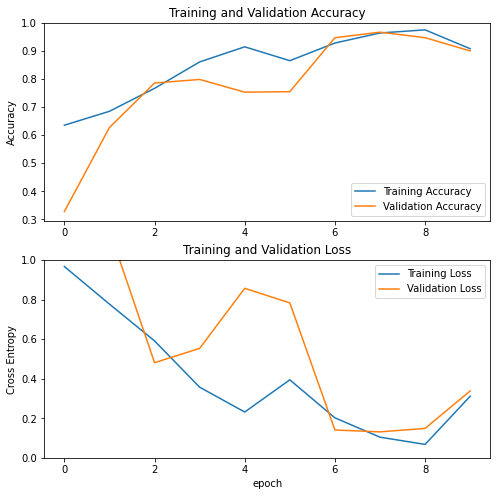

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
model.save("/content/drive/MyDrive/inceptionv3-flip-clahe-covid-19.model")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/inceptionv3-flip-clahe-covid-19.model/assets


In [ ]:
DIR="/content/drive/MyDrive/TEST"

In [ ]:
dataset_train=tf.keras.preprocessing.image_dataset_from_directory(
    DIR,
    labels="inferred",
    label_mode="int",
    class_names=CATEGORIES,
    color_mode="rgb",
    image_size=(IMG_SIZE,IMG_SIZE),
    shuffle=True,
    seed=123
)

Found 698 files belonging to 3 classes.


In [ ]:
the_model=tf.keras.models.load_model("/content/drive/MyDrive/inceptionv3-flip-clahe-covid-19.model")
the_model.summary()
predict=the_model.predict(dataset_train)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 4, 4, 2048)        21802784  
_________________________________________________________________
flatten_4 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 98307     
Total params: 21,901,091
Trainable params: 21,866,659
Non-trainable params: 34,432
_________________________________________________________________


In [ ]:
p=np.argmax(predict[15])